In [1]:
mzml_file_path = '/Users/simon/clms_data/collision_energy_comparison/new.mzML'
box_file_path = '/Users/simon/clms_data/collision_energy_comparison/new_box.csv'

In [2]:
import sys
import os
import pylab as plt
%matplotlib inline
# path to pymzm repo
sys.path.append('/Users/simon/git/pymzm')

In [3]:
from ms2_matching import MZMLFile,load_picked_boxes,map_boxes_to_scans

In [4]:
mzml_file_obj = MZMLFile(mzml_file_path)

boxes = load_picked_boxes(box_file_path)

Loaded 7422 scans


In [8]:
s2b,b2s = map_boxes_to_scans(mzml_file_obj,boxes,half_isolation_window = 0.5)

In [577]:
# grab all the MS2 scans
from ms2_matching import traverse_boxes_scans
boxes_with_multiple_scans = [b for b,s in b2s.items() if len(s) > 1]
start_scan = b2s[boxes_with_multiple_scans[197]][0]
relevant_scans,interesting_boxes = traverse_boxes_scans(b2s,s2b,start_scan)
relevant_scans = list(relevant_scans)
interesting_boxes = list(interesting_boxes)
print(len(interesting_boxes))
for i,scan in enumerate(relevant_scans):
    print(i,"MZ: {}, RT: {}".format(scan.precursor_mz,scan.rt_in_seconds))

2
0 MZ: 278.1233825683594, RT: 273.820203906
1 MZ: 278.12335205078125, RT: 225.4271300800002
2 MZ: 278.12335205078125, RT: 178.09153115200021
3 MZ: 278.1233215332031, RT: 257.57813517
4 MZ: 278.12322998046875, RT: 162.1640819530002
5 MZ: 278.12322998046875, RT: 194.2103376649998
6 MZ: 278.1231994628906, RT: 209.93341699200002
7 MZ: 278.1233825683594, RT: 241.49569916800021
8 MZ: 278.138427734375, RT: 251.9854591690002


In [578]:
sys.path.append('/Users/simon/git/mass-spec-utils/')
%load_ext autoreload
%autoreload 2
from spectrum import SpectralRecord
scan2spectrum = {}
for scan in relevant_scans:
    new_spectrum = SpectralRecord(scan.precursor_mz,scan.peaks,{},scan.source_file,scan.scan_no)
    scan2spectrum[scan] = new_spectrum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [579]:
from spectral_scoring_functions import cosine_similarity

In [580]:
import numpy as np
sim_mat = np.zeros((len(relevant_scans),len(relevant_scans)))
for i,scan in enumerate(relevant_scans):
    for j,scan2 in enumerate(relevant_scans):
        a,b = cosine_similarity(scan2spectrum[scan],scan2spectrum[scan2],0.2,0)
        sim_mat[i,j] = a

In [581]:
[r,c] = np.where(sim_mat == sim_mat.min())
print(r,c)
sim_mat.min()

[3 4] [4 3]


0.8458760356111358

Following image shows the cosine similarities between all pairs of these spectra. Numbering is as in the figure. Note that spectrum 4 is not in the plot (it's missing to the RHS).

The lowest similarity is 0.507, which is between spectra 4 and 5. Makes sense: 5 is far left centered on 234.077, and 4 is far right, on a different peak, when 234.077 has disappeared.

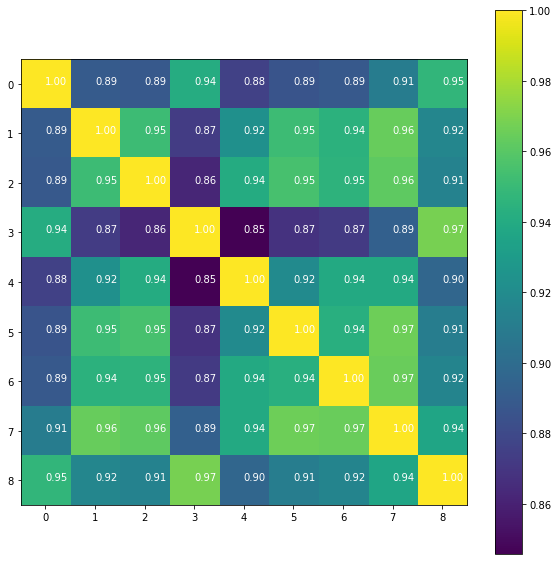

In [582]:
import pylab as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(sim_mat)
plt.colorbar()
ax = plt.gca()
for i in range(len(sim_mat)):
    for j in range(len(sim_mat)):
        ax.text(i,j,"{:.2f}".format(sim_mat[i,j]),color=[1,1,1])

In [583]:
def mirror_plot(spec1,spec2,normalised_peaks = True,**kwargs):
    plt.figure(**kwargs)
    if normalised_peaks:
        peaks1 = spec1.normalised_peaks
        peaks2 = spec2.normalised_peaks
    else:
        peaks1 = spec1.peaks
        pesk12 = spec2.peaks
    for mz,intensity in peaks1:
        plt.plot([mz,mz],[0,intensity],'r')
    for mz,intensity in peaks2:
        plt.plot([mz,mz],[0,-intensity],'b')

Now a specific example spectrum pair, in this case 3 and 6 

Similarity is 0.87


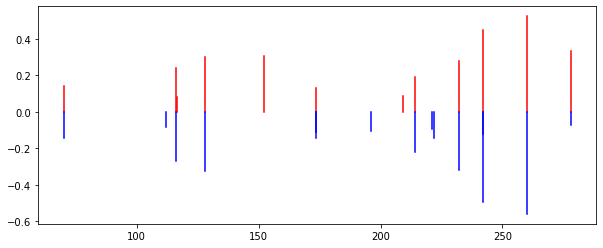

In [584]:
mirror_plot(scan2spectrum[relevant_scans[3]],
           scan2spectrum[relevant_scans[6]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[6][3]))

And 1 and 7

Similarity is 0.96


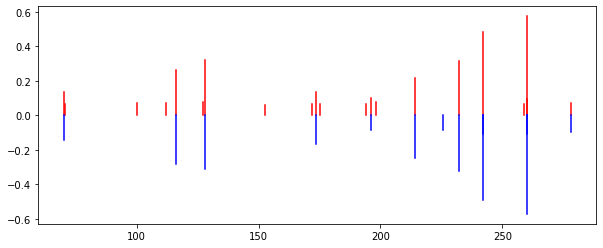

In [585]:
mirror_plot(scan2spectrum[relevant_scans[1]],
           scan2spectrum[relevant_scans[7]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[1][7]))

And e.g. 3 and 7. These are the same peak!

Similarity is 0.89


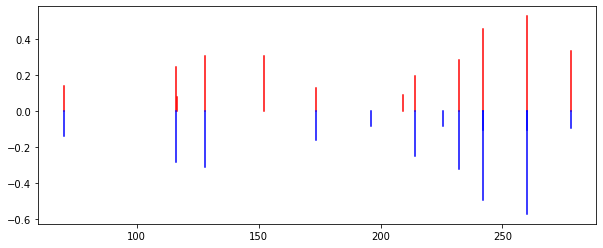

In [586]:
mirror_plot(scan2spectrum[relevant_scans[3]],
           scan2spectrum[relevant_scans[7]],figsize=(10,4))
print("Similarity is {:.2f}".format(sim_mat[3][7]))

To be able to deconvolve, we need the MS1 intensities of each of the peaks at the point where the fragmentations occur.

The following code makes two matrices needed for deconvolution:

1. A matrix of MS1 intensity versus scan - $A$
2. A matrix of MS2 intensity versus scan - $B$

assume that:

- $A$ has one row per MS2 scan and one column per MS1 peak
- $B$ has one row per MS2 scan and one column per unique MS2 m/z

Now, we assume that:

$B = A \times C$

where $C$ has one row per MS1 peak and one column per unique MS2 m/z. I.e. it is the actual MS2 spectra that we want.

So, with $A$ and $B$, we can try and infer $C$.

Can't find peak within 10 ppm, closest = 54.531232736119414
Can't find peak within 10 ppm, closest = 54.640953526332936
Can't find peak within 10 ppm, closest = 54.531232736119414
Can't find peak within 10 ppm, closest = 54.970115896973496
Can't find peak within 10 ppm, closest = 54.970115896973496
Can't find peak within 10 ppm, closest = 54.640953526332936
Can't find peak within 10 ppm, closest = 54.970115896973496
Can't find peak within 10 ppm, closest = 29.844054938077427
Can't find peak within 10 ppm, closest = 55.07983668718701
Can't find peak within 10 ppm, closest = 54.311791155692376
Can't find peak within 10 ppm, closest = 54.4215119459059
Can't find peak within 10 ppm, closest = 54.860395106759974


Text(0, 0.5, 'MS2 scans')

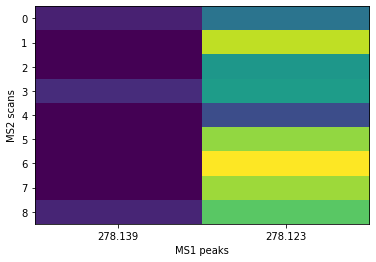

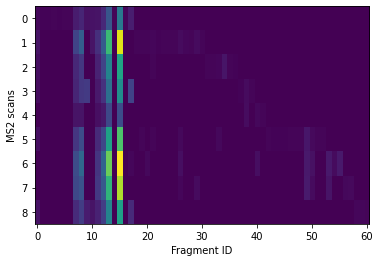

In [587]:
from ms2_matching import create_deconvolution_matrices
A,B,frags_idx,box_idx = create_deconvolution_matrices(relevant_scans,interesting_boxes)
plt.figure()
plt.imshow(A,aspect='auto')
plt.xlabel('MS1 peaks')
plt.xticks(range(len(interesting_boxes)),["{:.3f}".format(b.mz) for b in interesting_boxes])
plt.ylabel('MS2 scans')
plt.figure()
plt.imshow(B,aspect='auto')
plt.xlabel('Fragment ID')
plt.ylabel('MS2 scans')

In [588]:
from ms2_matching import deconvolve
out_mat = deconvolve(A,B,frags_idx)

Looks nasty, scared
36 pairs of observations (of 36.0) have correlation > 0.75
[[ 78136.76018422 325567.79170691]
 [     0.         768394.431347  ]
 [     0.         450814.23446094]
 [106545.20209212 469003.17432652]
 [     0.         199734.13616295]
 [     0.         712968.92936157]
 [     0.         850319.71613871]
 [     0.         726165.90811097]
 [ 88699.57708586 631877.66502332]]


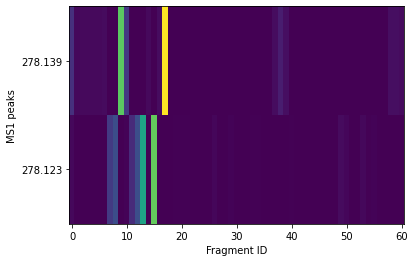

In [589]:
plt.imshow(out_mat,aspect='auto')
plt.xlabel('Fragment ID')
plt.ylabel('MS1 peaks')
h = plt.yticks(range(len(interesting_boxes)),["{:.3f}".format(b.mz) for b in interesting_boxes])

Here are the deconvolved intensities

In [590]:
heads = ["{:3d}".format(-1)]+["{:8s}".format("")]+["{:8.3f}".format(b.mz) for b in interesting_boxes]
print("\t".join(heads))
for f,pos in frags_idx.items():
    line = ["{:3d}".format(pos)]+["{:8.2f}".format(f)]
    for i in range(len(interesting_boxes)):
        line.append("{:8.3f}".format(out_mat[i,pos]))
    print("\t".join(line))

 -1	        	 278.139	 278.123
  0	   70.06	   0.048	   0.008
  1	   71.16	   0.008	   0.000
  2	   71.90	   0.008	   0.000
  3	   72.65	   0.009	   0.000
  4	   75.89	   0.008	   0.000
  5	   81.23	   0.009	   0.000
  6	   96.35	   0.010	   0.000
  7	  116.07	   0.000	   0.058
  8	  128.07	   0.000	   0.082
  9	  152.11	   0.258	   0.000
 10	  173.44	   0.057	   0.004
 11	  214.11	   0.000	   0.042
 12	  232.12	   0.000	   0.082
 13	  242.10	   0.000	   0.199
 14	  243.25	   0.009	   0.000
 15	  260.11	   0.000	   0.263
 16	  278.05	   0.011	   0.000
 17	  278.14	   0.344	   0.001
 18	   70.54	   0.000	   0.001
 19	  100.08	   0.000	   0.001
 20	  112.08	   0.000	   0.002
 21	  127.04	   0.000	   0.002
 22	  152.76	   0.000	   0.001
 23	  171.99	   0.000	   0.001
 24	  175.32	   0.000	   0.001
 25	  194.01	   0.000	   0.001
 26	  196.10	   0.000	   0.006
 27	  198.11	   0.000	   0.001
 28	  258.78	   0.000	   0.001
 29	  260.05	   0.000	   0.003
 30	  278.22	   0.000	   0.001
 31	   7

In [591]:
for box,pos in box_idx.items():
    print(box.mz,pos)

278.1385192871094 0
278.123291015625 1


## Correlation plots

Show how the MS1 intensity correlates with the MS2 intensity of particular fragments

In [592]:
reverse_frags_idx = {v:k for k,v in frags_idx.items()}

In [593]:
def make_correlation_plot(frag_pos):
    plt.figure(figsize=(15,4))
    frag_mz = reverse_frags_idx[frag_pos]
    for box,pos in box_idx.items():
        plt.subplot(1,3,pos+1)
        plt.plot(A[:,pos],B[:,frag_pos],'ro')
        plt.title("{:.3f} -> {:.2f}".format(box.mz,out_mat[pos,frag_pos]))
        plt.xlabel('MS1 intensity')
        plt.ylabel('{:.2f} intensity'.format(frag_mz))

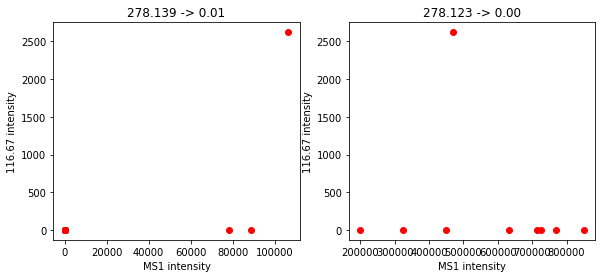

In [594]:
make_correlation_plot(37)

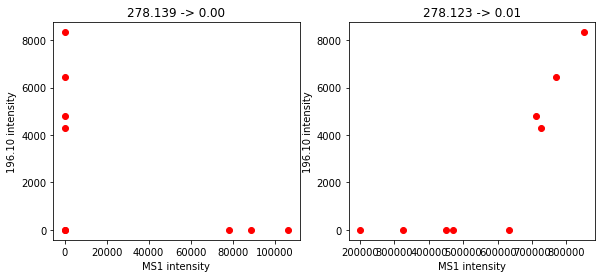

In [595]:
make_correlation_plot(26)

Some fragments end up in more than one spectrum.

- For example, m/z = 144.99 (plotted below).
- It correlates with both 234.097 and 234.077, although best with 234.077

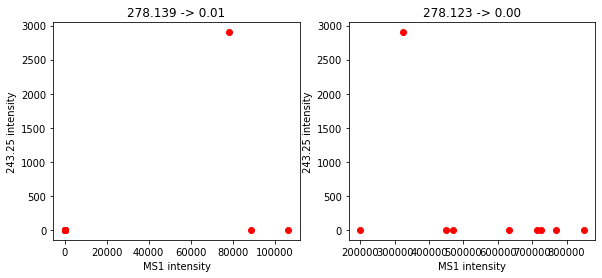

In [596]:
make_correlation_plot(14)

Make spectrum objects for the new spectra

In [597]:
new_spectra = {}
for box,bpos in box_idx.items():
    peaks = []
    for f,fpos in frags_idx.items():
        intensity = out_mat[bpos,fpos]
        if intensity > 0:
            peaks.append((f,intensity))
        peaks.sort(key = lambda x: x[0]) # Don't forget this...v important
    new_spectra[box] = SpectralRecord(box.mz,peaks,None,None,None)

Compute their similarity with one another -- this could be a diagnostic..I think it should be low

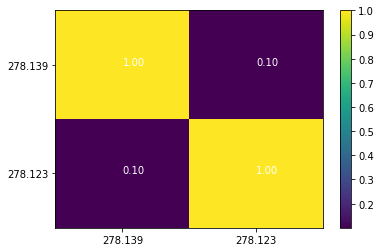

In [598]:
new_sim_mat = np.zeros((len(box_idx),len(box_idx)))
for box,bpos in box_idx.items():
    for box2,bpos2 in box_idx.items():
        a,b = cosine_similarity(new_spectra[box],new_spectra[box2],0.2,0)
        new_sim_mat[bpos,bpos2] = a
labels = ["" for box in box_idx]
for box,pos in box_idx.items():
    labels[pos] = "{:.3f}".format(box.mz)
plt.imshow(new_sim_mat,aspect='auto')
plt.colorbar()
plt.xticks(range(len(box_idx)),labels)
plt.yticks(range(len(box_idx)),labels)
ax = plt.gca()
for i in range(len(box_idx)):
    for j in range(len(box_idx)):
        ax.text(i,j,"{:.2f}".format(new_sim_mat[i,j]),color=[1,1,1])

In [599]:
def plot_spectra(spectrum,normalised_peaks = True,**kwargs):
    plt.figure(**kwargs)
    if normalised_peaks:
        peaks = spectrum.normalised_peaks
    else:
        peaks = spectrum.peaks
    for mz,intensity in peaks:
        plt.plot([mz,mz],[0,intensity],'k')

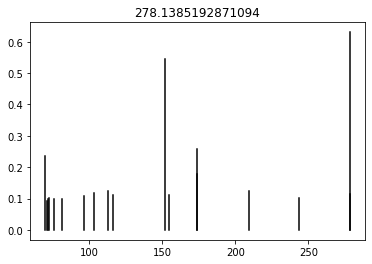

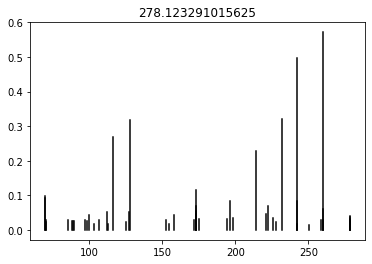

In [600]:
for box,spectrum in new_spectra.items():
    plot_spectra(spectrum)
    plt.title(box.mz)